In [1]:
# py38 environment, python = 3.8
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc

### QC

In [ ]:
gex_all = sc.read_h5ad('concatenate_gex_all.h5ad')

In [ ]:
sc.pp.calculate_qc_metrics(gex_all, inplace = True)

Text(0.5, 1.0, 'Correlation = 0.973')

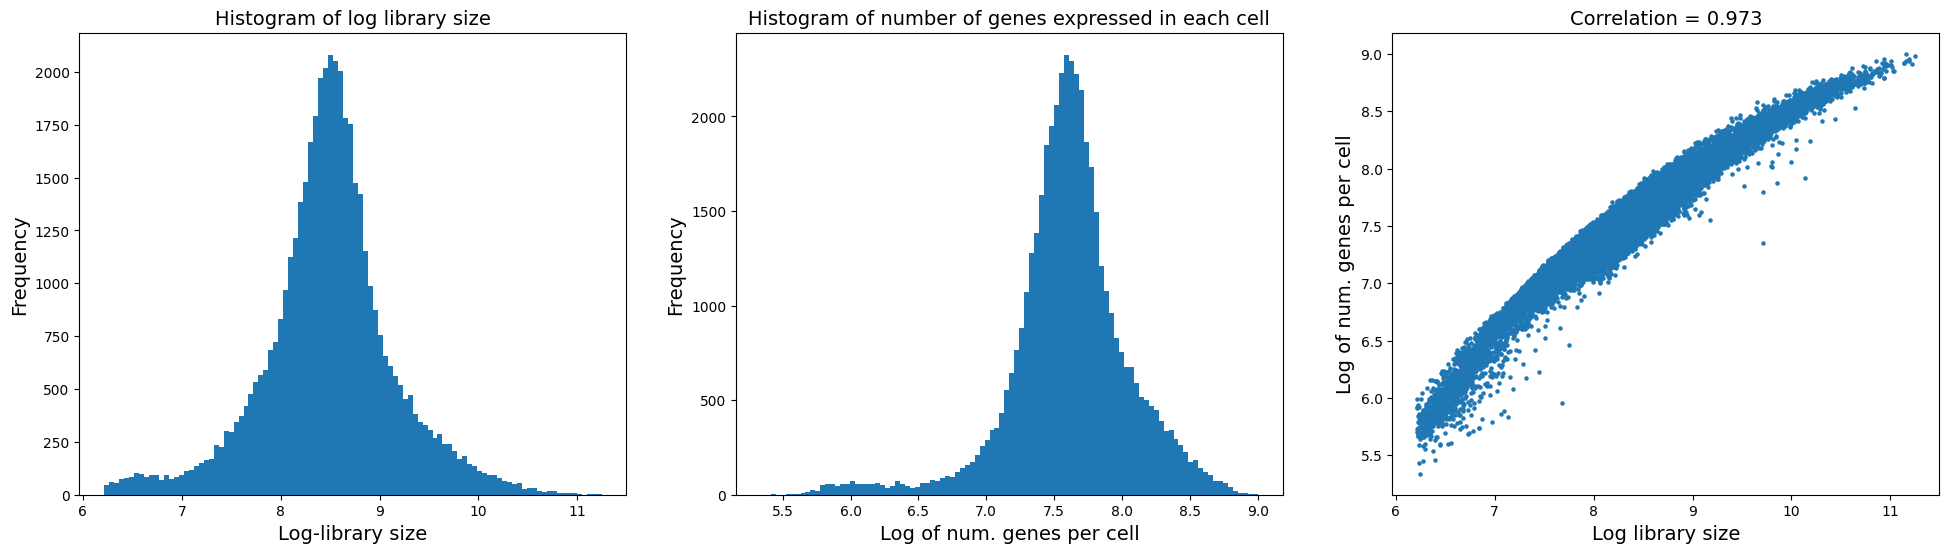

In [ ]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(gex_all.obs['log1p_total_counts'], bins = 100); #logarithm of (1 + x), natural logarithm
ax.set_xlabel('Log-library size', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log library size', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(gex_all.obs['log1p_n_genes_by_counts'], bins = 100);
ax.set_xlabel('Log of num. genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of genes expressed in each cell', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
x = gex_all.obs['log1p_total_counts']
y = gex_all.obs['log1p_n_genes_by_counts']
ax.scatter(x, y, s = 5);
ax.set_ylabel('Log of num. genes per cell', fontsize = 14)
ax.set_xlabel('Log library size', fontsize = 14)
corr_coef = np.corrcoef(x, y)[0, 1]
ax.set_title('Correlation = ' + str(round(corr_coef, 3)), fontsize = 14)

(0.0, 1000.0)

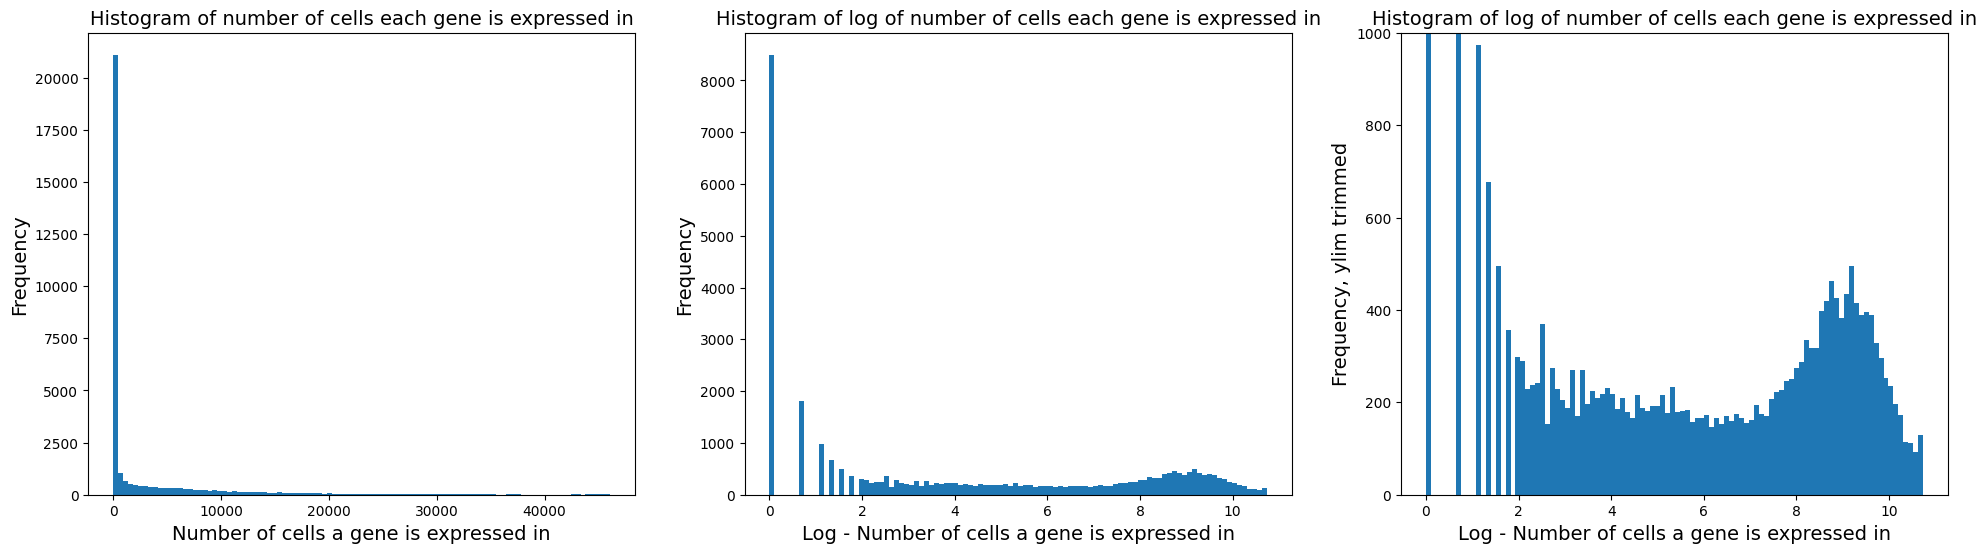

In [ ]:
# number of genes each cell is expressed
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(gex_all.var['n_cells_by_counts'], bins = 100);
ax.set_xlabel('Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(np.log(gex_all.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.hist(np.log(gex_all.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency, ylim trimmed', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)
ax.set_ylim([0, 1000])

In [ ]:
#Remove lowly expressed genes
sc.pp.filter_genes(gex_all, min_cells = np.exp(2))
gex_all

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 46095 × 18896
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [ ]:
# Identify mitochondria genes, calculate mito gene fraction for future QC usage
mito_genes = gex_all.var_names[gex_all.var_names.str.startswith('mt-')]

index_mito_genes = [gex_all.var_names.get_loc(j) for j in mito_genes]
mito_frac = np.asarray(np.sum(gex_all.X[:, index_mito_genes], axis = 1)/np.sum(gex_all.X, axis = 1)).squeeze() * 100
# np.sum(gex_all.X[:, index_mito_genes], axis=1) total counts of mito genes per cell
# np.sum(gex_all.X, axis=1) counts of all genes per cell

gex_all.obs['mito_frac'] = mito_frac
gex_all


AnnData object with n_obs × n_vars = 46095 × 18896
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

Text(0, 0.5, '% MT-content')

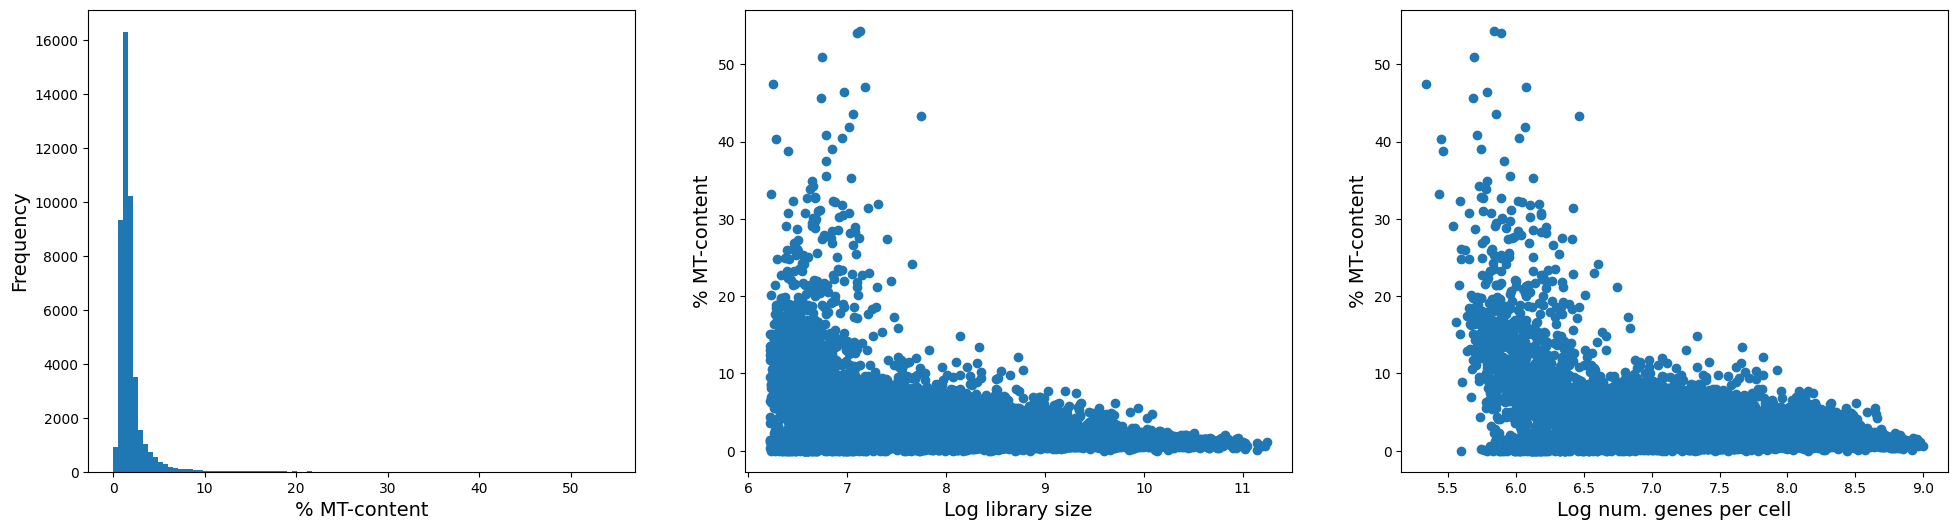

In [ ]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(gex_all.obs['mito_frac'], 100);
ax.set_xlabel('% MT-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(gex_all.obs['log1p_total_counts'], gex_all.obs['mito_frac']);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(gex_all.obs['log1p_n_genes_by_counts'], gex_all.obs['mito_frac']);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

# Not filtering out the cells with a high mito content with a hard cut, but later after clustering

In [ ]:
# Identify Ribo-genes
ribo_genes = gex_all.var_names[gex_all.var_names.str.startswith(('Rps', 'Rpl', 'Gm'))]
index_ribo_genes = [gex_all.var_names.get_loc(j) for j in ribo_genes]
ribo_frac = np.asarray(np.sum(gex_all.X[:, index_ribo_genes], axis = 1)/np.sum(gex_all.X, axis = 1)).squeeze() * 100
gex_all.obs['ribo_frac'] = ribo_frac

gex_all


AnnData object with n_obs × n_vars = 46095 × 18896
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

Text(0, 0.5, '% Ribo-content')

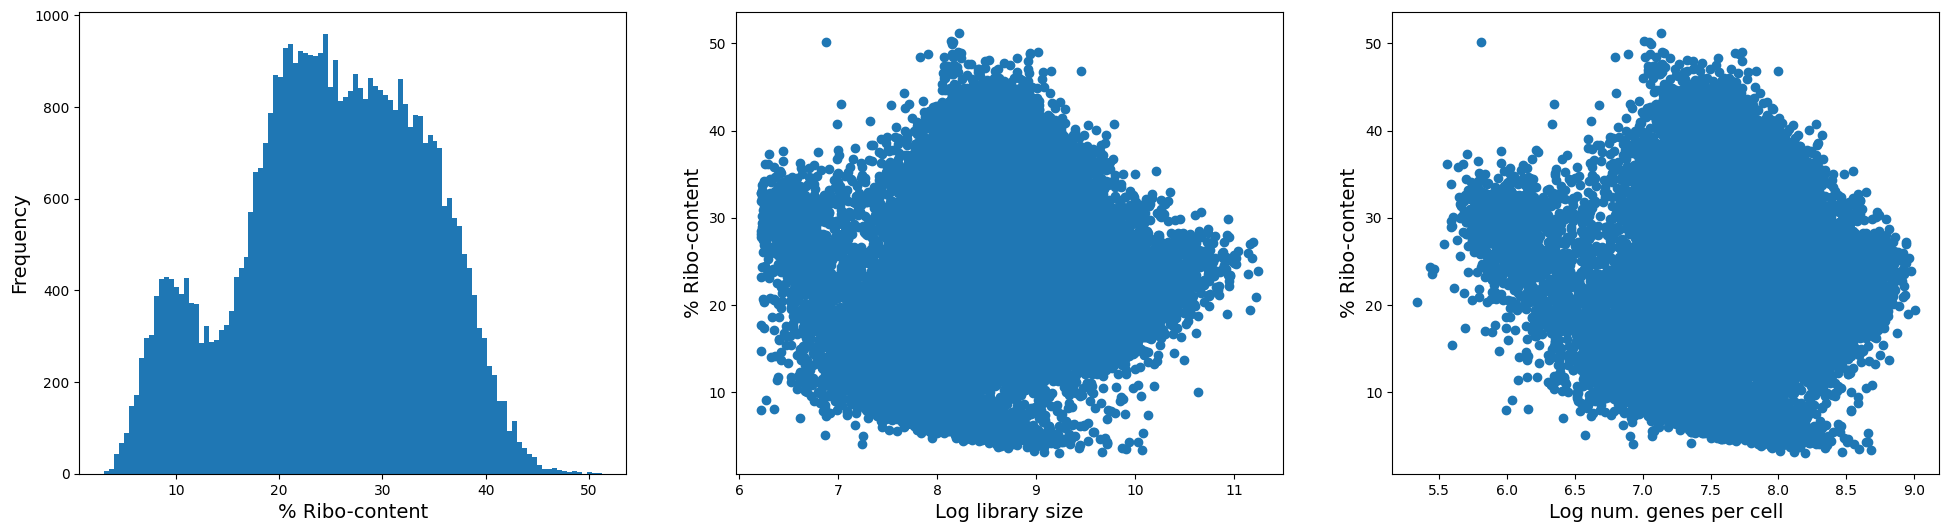

In [ ]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(gex_all.obs['ribo_frac'], 100);
ax.set_xlabel('% Ribo-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1,3,2)
ax.scatter(gex_all.obs['log1p_total_counts'], gex_all.obs['ribo_frac']);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% Ribo-content', fontsize = 14)

ax = fig.add_subplot(1,3,3)
ax.scatter(gex_all.obs['log1p_n_genes_by_counts'], gex_all.obs['ribo_frac']);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% Ribo-content', fontsize = 14)

In [ ]:
# remove ribo genes
ribo_mk = np.in1d(gex_all.var_names.values.astype(str), ribo_genes)
gex_all = gex_all[:,~ribo_mk]

In [ ]:
gex_all

View of AnnData object with n_obs × n_vars = 46095 × 16096
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Normalization

In [ ]:
gex_all.layers['raw_data'] = gex_all.X.copy()
gex_all

/Users/gaos1/anaconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 46095 × 16096
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'raw_data'

In [ ]:
sc.pp.normalize_total(gex_all, inplace = True) #gene expression counts by the total counts over all genes in that cell
gex_all.layers['norm_counts'] = gex_all.X.copy()

gex_all.X = np.log2(gex_all.X.toarray() + 1)
import scipy
gex_all.layers['zs_norm_log'] = scipy.stats.zscore(gex_all.X) #log2 transformation to the normalized counts

##### save

In [ ]:
gex_all.write_h5ad('normalized_gex_all_no_ribo.h5ad')

## v1.0 analysis on all cells, without removing ribo genes

### HVG
highly variable genes

In [2]:
adata = sc.read_h5ad('normalized_gex_all.h5ad')

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# remove ribo genes, and cells with high mito fraction

In [3]:
sc.pp.highly_variable_genes(adata, layer = 'raw_data', n_top_genes = 4000, flavor = 'seurat_v3')

In [4]:
adata.uns['id_hvg'] = np.where(adata.var['highly_variable'])[0]

### PCA

In [5]:
sc.tl.pca(adata, n_comps=100, use_highly_variable=True)

Text(0, 0.5, '% Variance Explained')

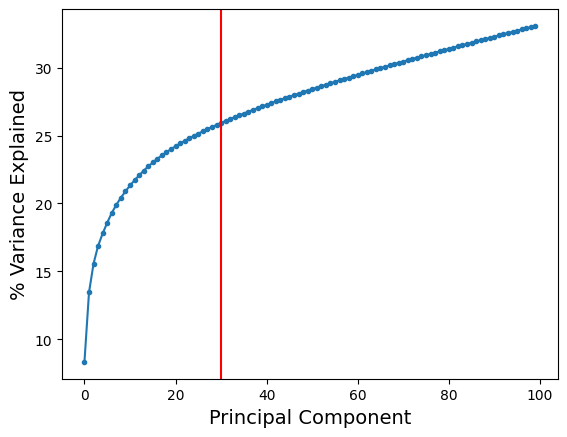

In [6]:
plt.plot(range(len(adata.uns['pca']['variance_ratio'])), np.cumsum(adata.uns['pca']['variance_ratio']) * 100, '.-')
plt.axvline(30, color = 'r')
plt.xlabel('Principal Component', fontsize = 14)
plt.ylabel('% Variance Explained', fontsize = 14)

In [10]:
adata.obsm['X_pca'] = adata.obsm['X_pca'][:, 0:30]
adata.varm['PCs'] = adata.varm['PCs'][:, 0:30]
# ensure that loadings of only HVG are kept track of
adata.uns['loadings'] = adata.varm['PCs'][adata.var['highly_variable'], :]
adata.uns['loadings'] = adata.uns['loadings'][:, 0:30]

### KNN and UMAP

In [11]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/umap/distances.

In [12]:
sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


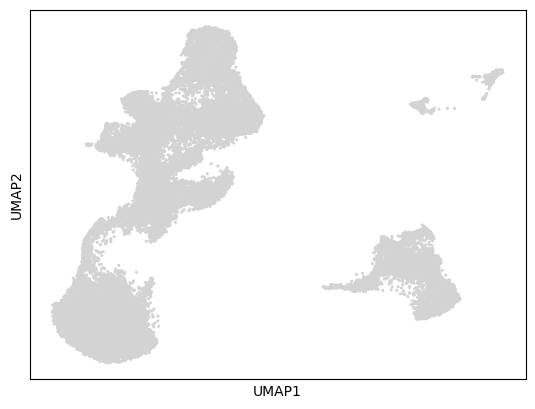

In [13]:
sc.pl.umap(adata, size = 20)

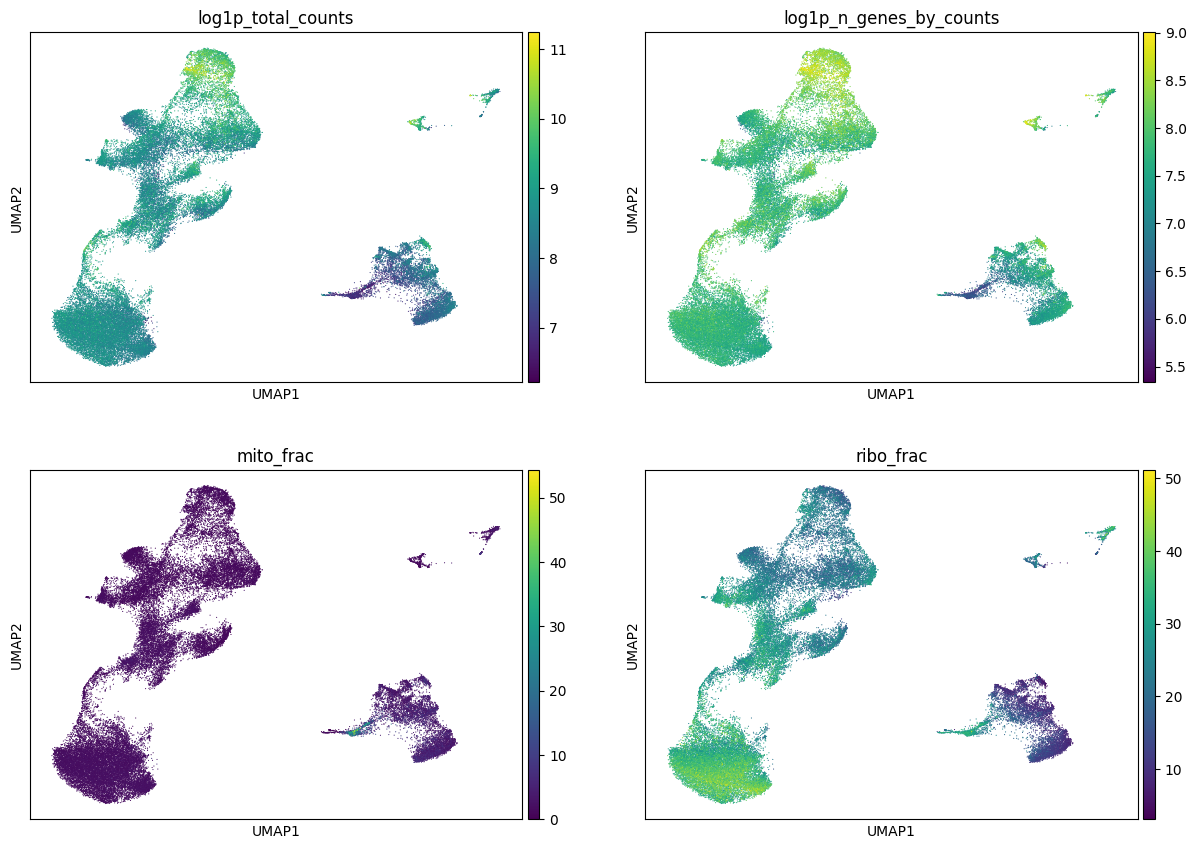

In [14]:
sc.pl.umap(adata, color = ['log1p_total_counts', 'log1p_n_genes_by_counts', 'mito_frac', 'ribo_frac'], 
           cmap = 'viridis', ncols = 2)

In [15]:
adata

AnnData object with n_obs × n_vars = 46095 × 14907
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'loadings', 'neighbors_30', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data', 'zs_norm_log'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


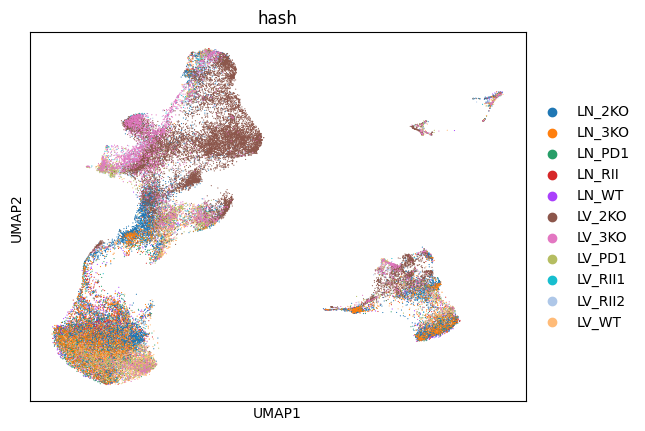

In [17]:
sc.pl.umap(adata, color = 'hash', cmap = 'plasma', ncols = 3, vmin = 'p1', vmax = 'p99')

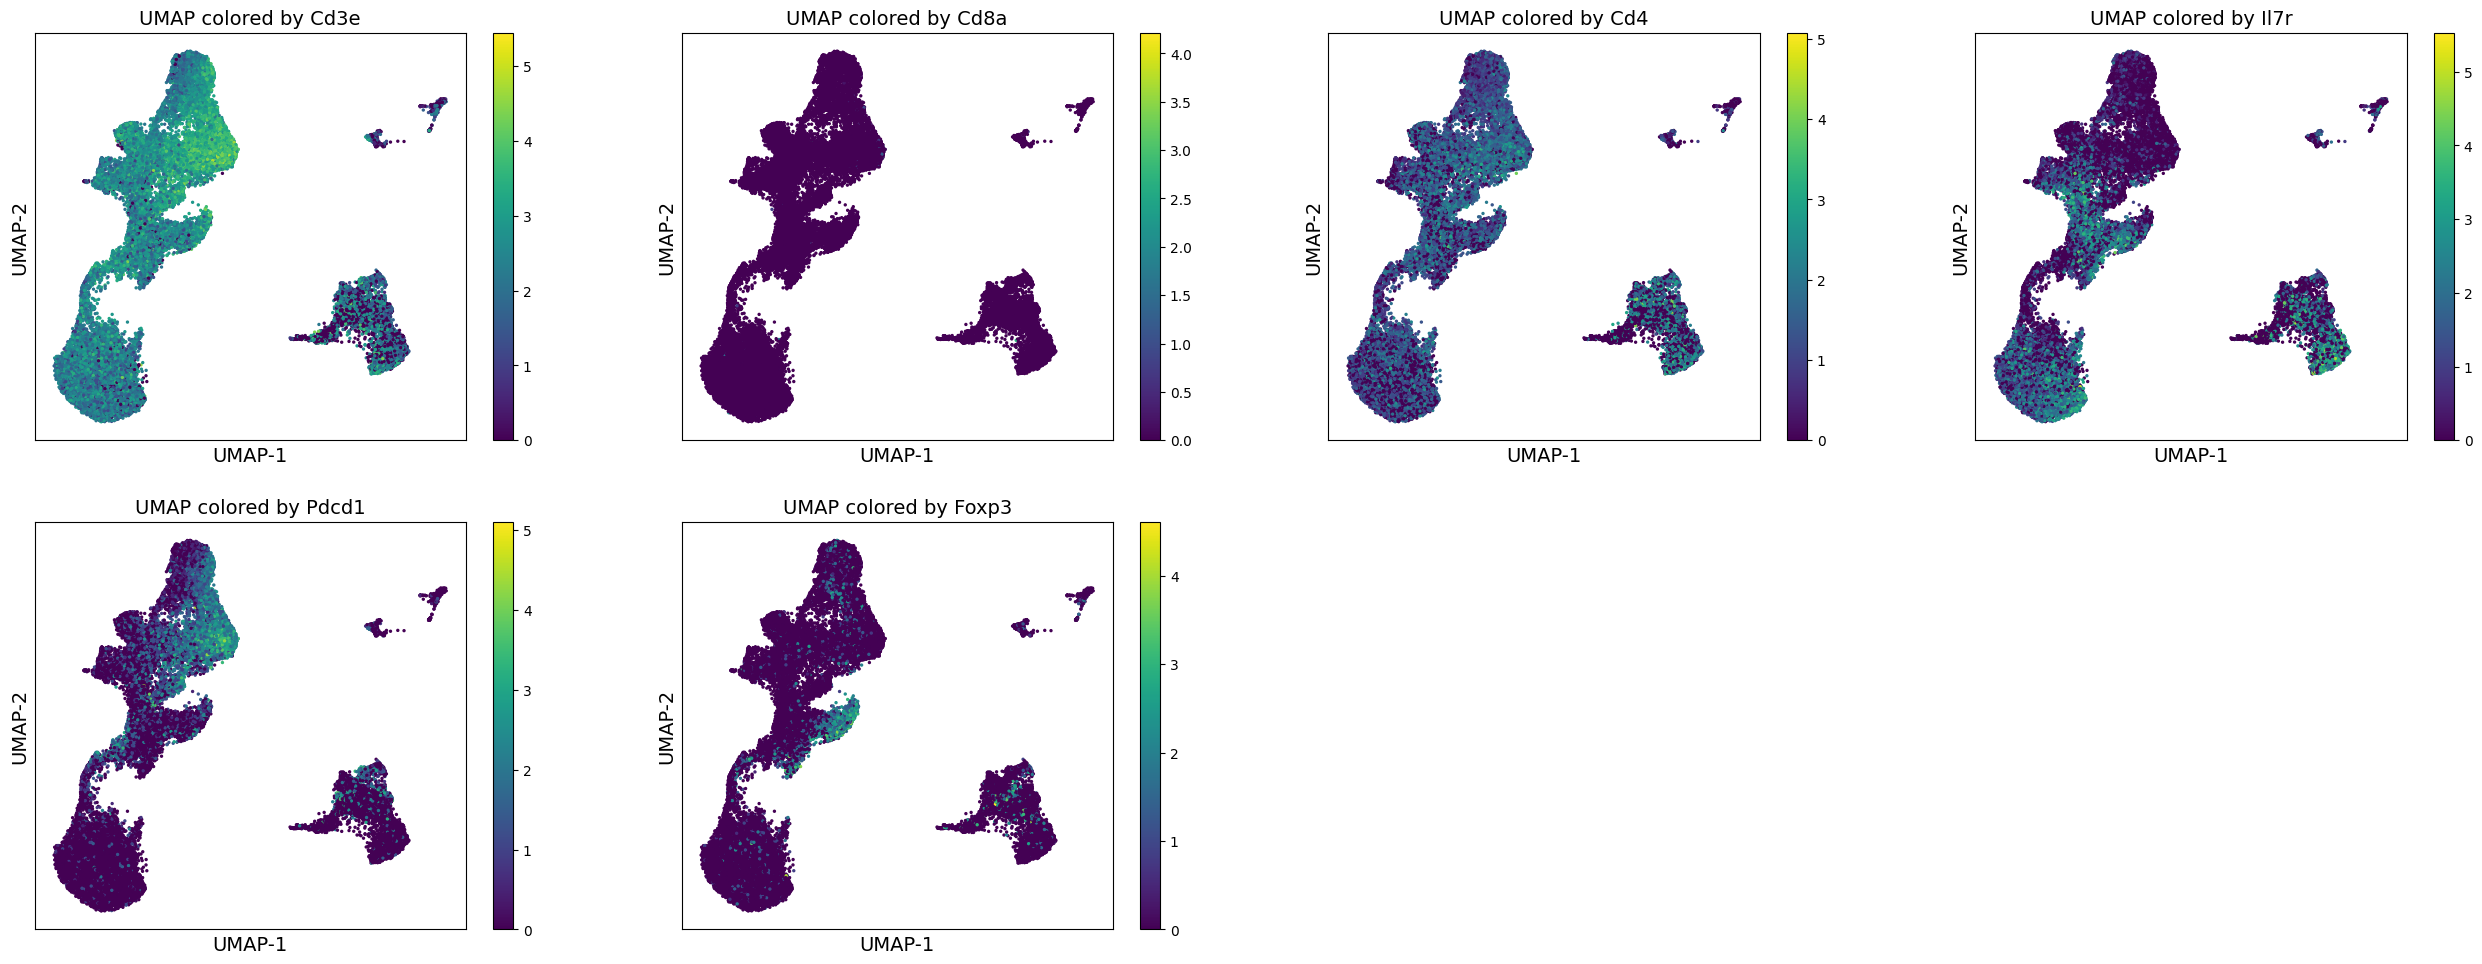

In [19]:
genes = ['Cd3e', 'Cd8a', 'Cd4', 'Il7r', 'Pdcd1', 'Foxp3']

fig_nrow = 3
fig_ncol = 4

fig = plt.figure(figsize = (8*fig_ncol, 6*fig_nrow))
count = 0
for gene_name in genes:
    ax = fig.add_subplot(fig_nrow, fig_ncol, count + 1)
    col_gene = adata.X[:, adata.var_names.get_loc(gene_name)]
    im1 = ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s = 2, c = col_gene, 
                    cmap = 'viridis')
    ax.set_xlabel('UMAP-1', fontsize = 14)
    ax.set_ylabel('UMAP-2', fontsize = 14)
    ax.set_title('UMAP colored by ' + gene_name, fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(im1)
    count = count + 1
    
# To save, please uncomment the following line of code:
# fig.savefig(output_directory, 'UMAP_colored_by_genes.png', dpi = 150, bbox_inches = 'tight')

In [21]:
adata.obs['hash']

AAACCTGAGTGTGAAT-1     LN_WT
AAACCTGCAAATTGCC-1     LN_WT
AAACCTGGTACATGTC-1     LN_WT
AAACCTGGTACGCTGC-1     LN_WT
AAACCTGTCCAAGTAC-1     LN_WT
                       ...  
TTTGGTTGTTCCCTTG-1    LV_3KO
TTTGGTTGTTGAACTC-1    LV_3KO
TTTGTCACACCGGAAA-1    LV_3KO
TTTGTCAGTATGAAAC-1    LV_3KO
TTTGTCATCAAACGGG-1    LV_3KO
Name: hash, Length: 46095, dtype: category
Categories (11, object): ['LN_2KO', 'LN_3KO', 'LN_PD1', 'LN_RII', ..., 'LV_PD1', 'LV_RII1', 'LV_RII2', 'LV_WT']

### Clustering

In [22]:
sc.external.tl.phenograph(adata, clustering_algo='louvain', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=1)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.2401297092437744 seconds
Jaccard graph constructed in 7.2796950340271 seconds
Wrote graph to binary file in 0.8932278156280518 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.851567
After 2 runs, maximum modularity is Q = 0.85312
Louvain completed 22 runs in 46.22532796859741 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 59.80190587043762 seconds


In [23]:
import scipy
adata.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata.obsp['pheno_jaccard_ig'])

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


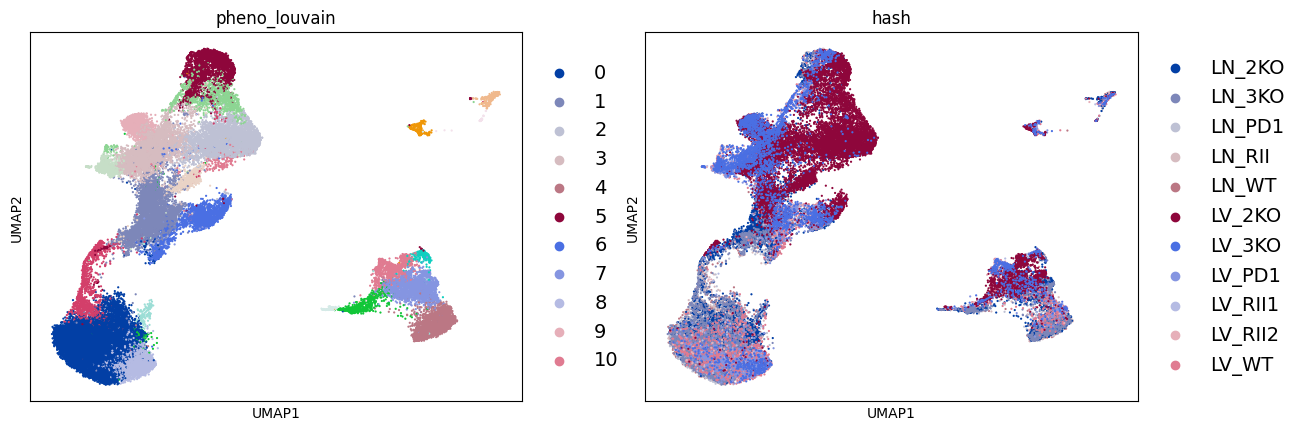

In [27]:
sc.pl.umap(adata, color = ['pheno_louvain', 'hash'], s = 10, palette = sc.pl.palettes.zeileis_28, legend_fontsize = 14)

In [25]:
sc.tl.rank_genes_groups(adata, groupby = 'pheno_louvain', groups='all', reference='rest', method='wilcoxon')

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarni

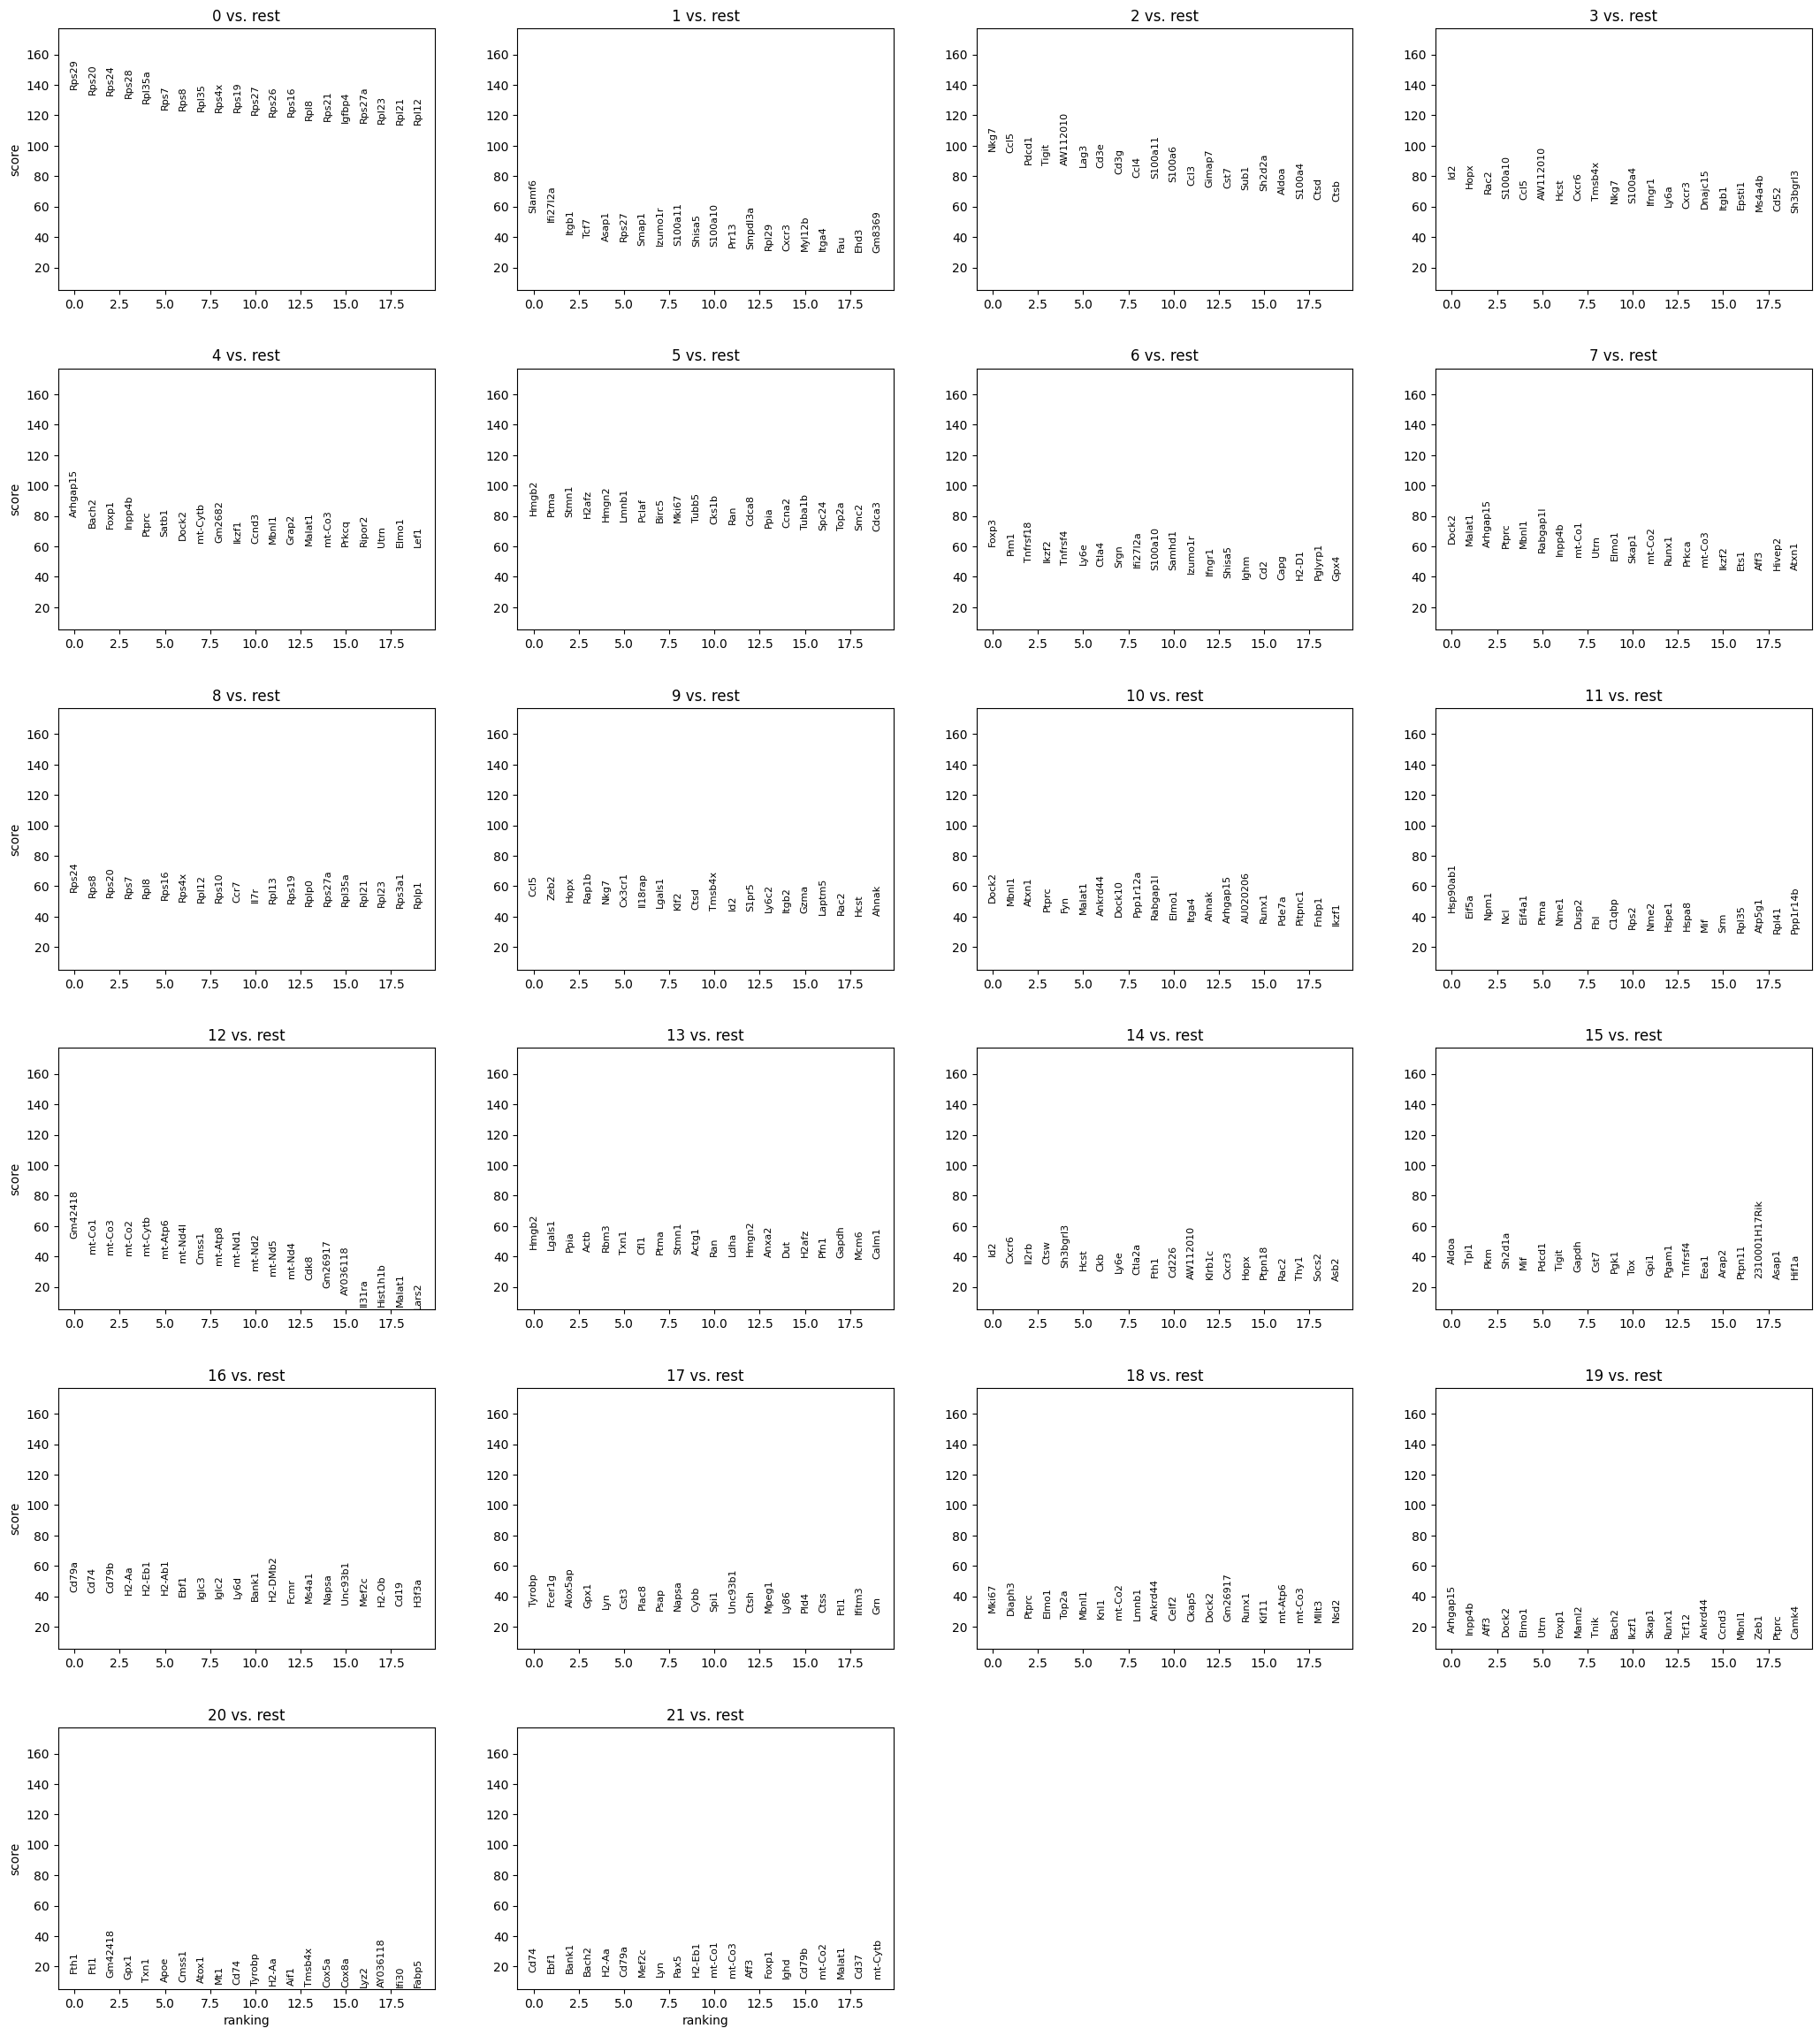

In [26]:
sc.pl.rank_genes_groups(adata)

### Conclusion

- the first cluster is dominated by ribosomal genes, not informative for this project
- should redo the analysis after remove all the ribosomal genes

## v1.1 remove ribo genes

In [ ]:
# see section QC on how the ribo genes are removed
adata = sc.read_h5ad('normalized_gex_all_no_ribo.h5ad')

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# remove ribo genes, and cells with high mito fraction
adata

AnnData object with n_obs × n_vars = 46095 × 16096
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'norm_counts', 'raw_data', 'zs_norm_log'

In [ ]:
# HVG
sc.pp.highly_variable_genes(adata, layer = 'raw_data', n_top_genes = 4000, flavor = 'seurat_v3')
adata.uns['id_hvg'] = np.where(adata.var['highly_variable'])[0]

In [ ]:
# PCA
sc.tl.pca(adata, n_comps=100, use_highly_variable=True)

Text(0, 0.5, '% Variance Explained')

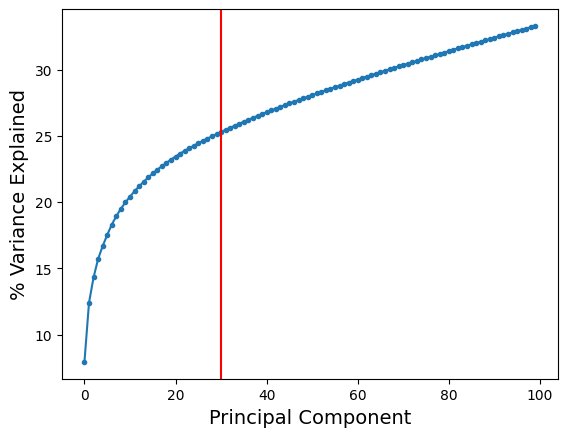

In [ ]:
plt.plot(range(len(adata.uns['pca']['variance_ratio'])), np.cumsum(adata.uns['pca']['variance_ratio']) * 100, '.-')
plt.axvline(30, color = 'r')
plt.xlabel('Principal Component', fontsize = 14)
plt.ylabel('% Variance Explained', fontsize = 14)

In [ ]:
adata.obsm['X_pca'] = adata.obsm['X_pca'][:, 0:30]
adata.varm['PCs'] = adata.varm['PCs'][:, 0:30]
# ensure that loadings of only HVG are kept track of
adata.uns['loadings'] = adata.varm['PCs'][adata.var['highly_variable'], :]
adata.uns['loadings'] = adata.uns['loadings'][:, 0:30]

### KNN and UMAP

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep='X_pca', metric='euclidean', key_added='neighbors_30')

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/umap/distances.

In [ ]:
sc.tl.umap(adata, neighbors_key = 'neighbors_30', min_dist=0.1)

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


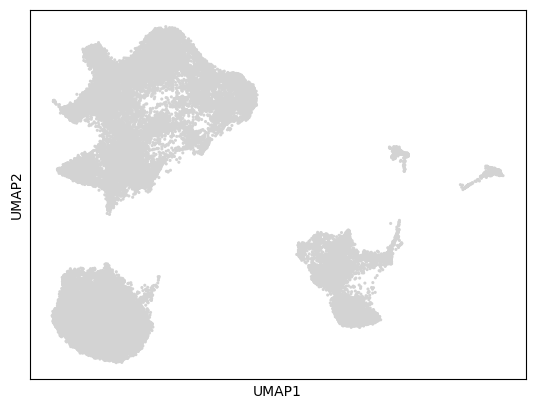

In [ ]:
sc.pl.umap(adata, size = 20)

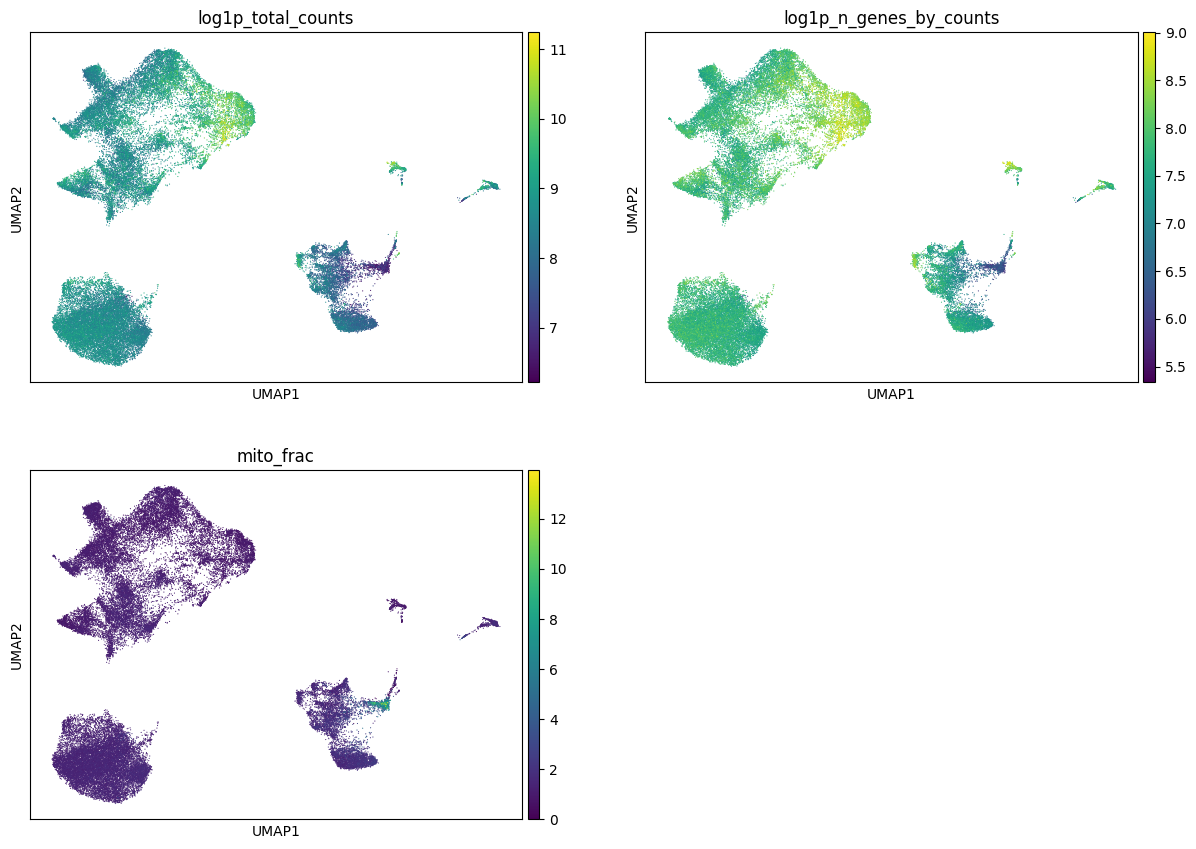

In [ ]:
sc.pl.umap(adata, color = ['log1p_total_counts', 'log1p_n_genes_by_counts', 'mito_frac'], 
           cmap = 'viridis', ncols = 2)

In [ ]:
adata

AnnData object with n_obs × n_vars = 46095 × 16096
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'loadings', 'neighbors_30', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data', 'zs_norm_log'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities'

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


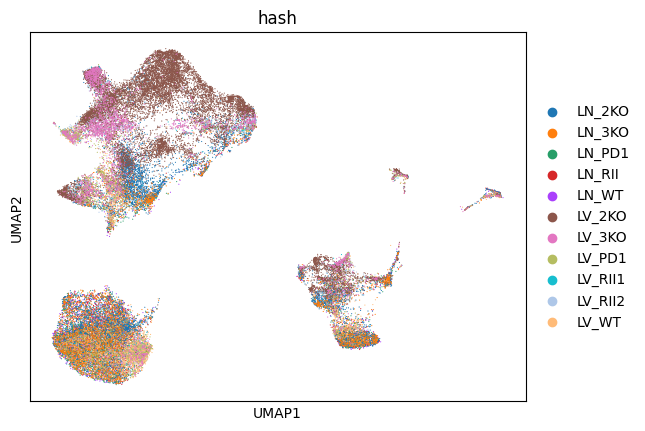

In [ ]:
sc.pl.umap(adata, color = 'hash', cmap = 'plasma', ncols = 3, vmin = 'p1', vmax = 'p99')

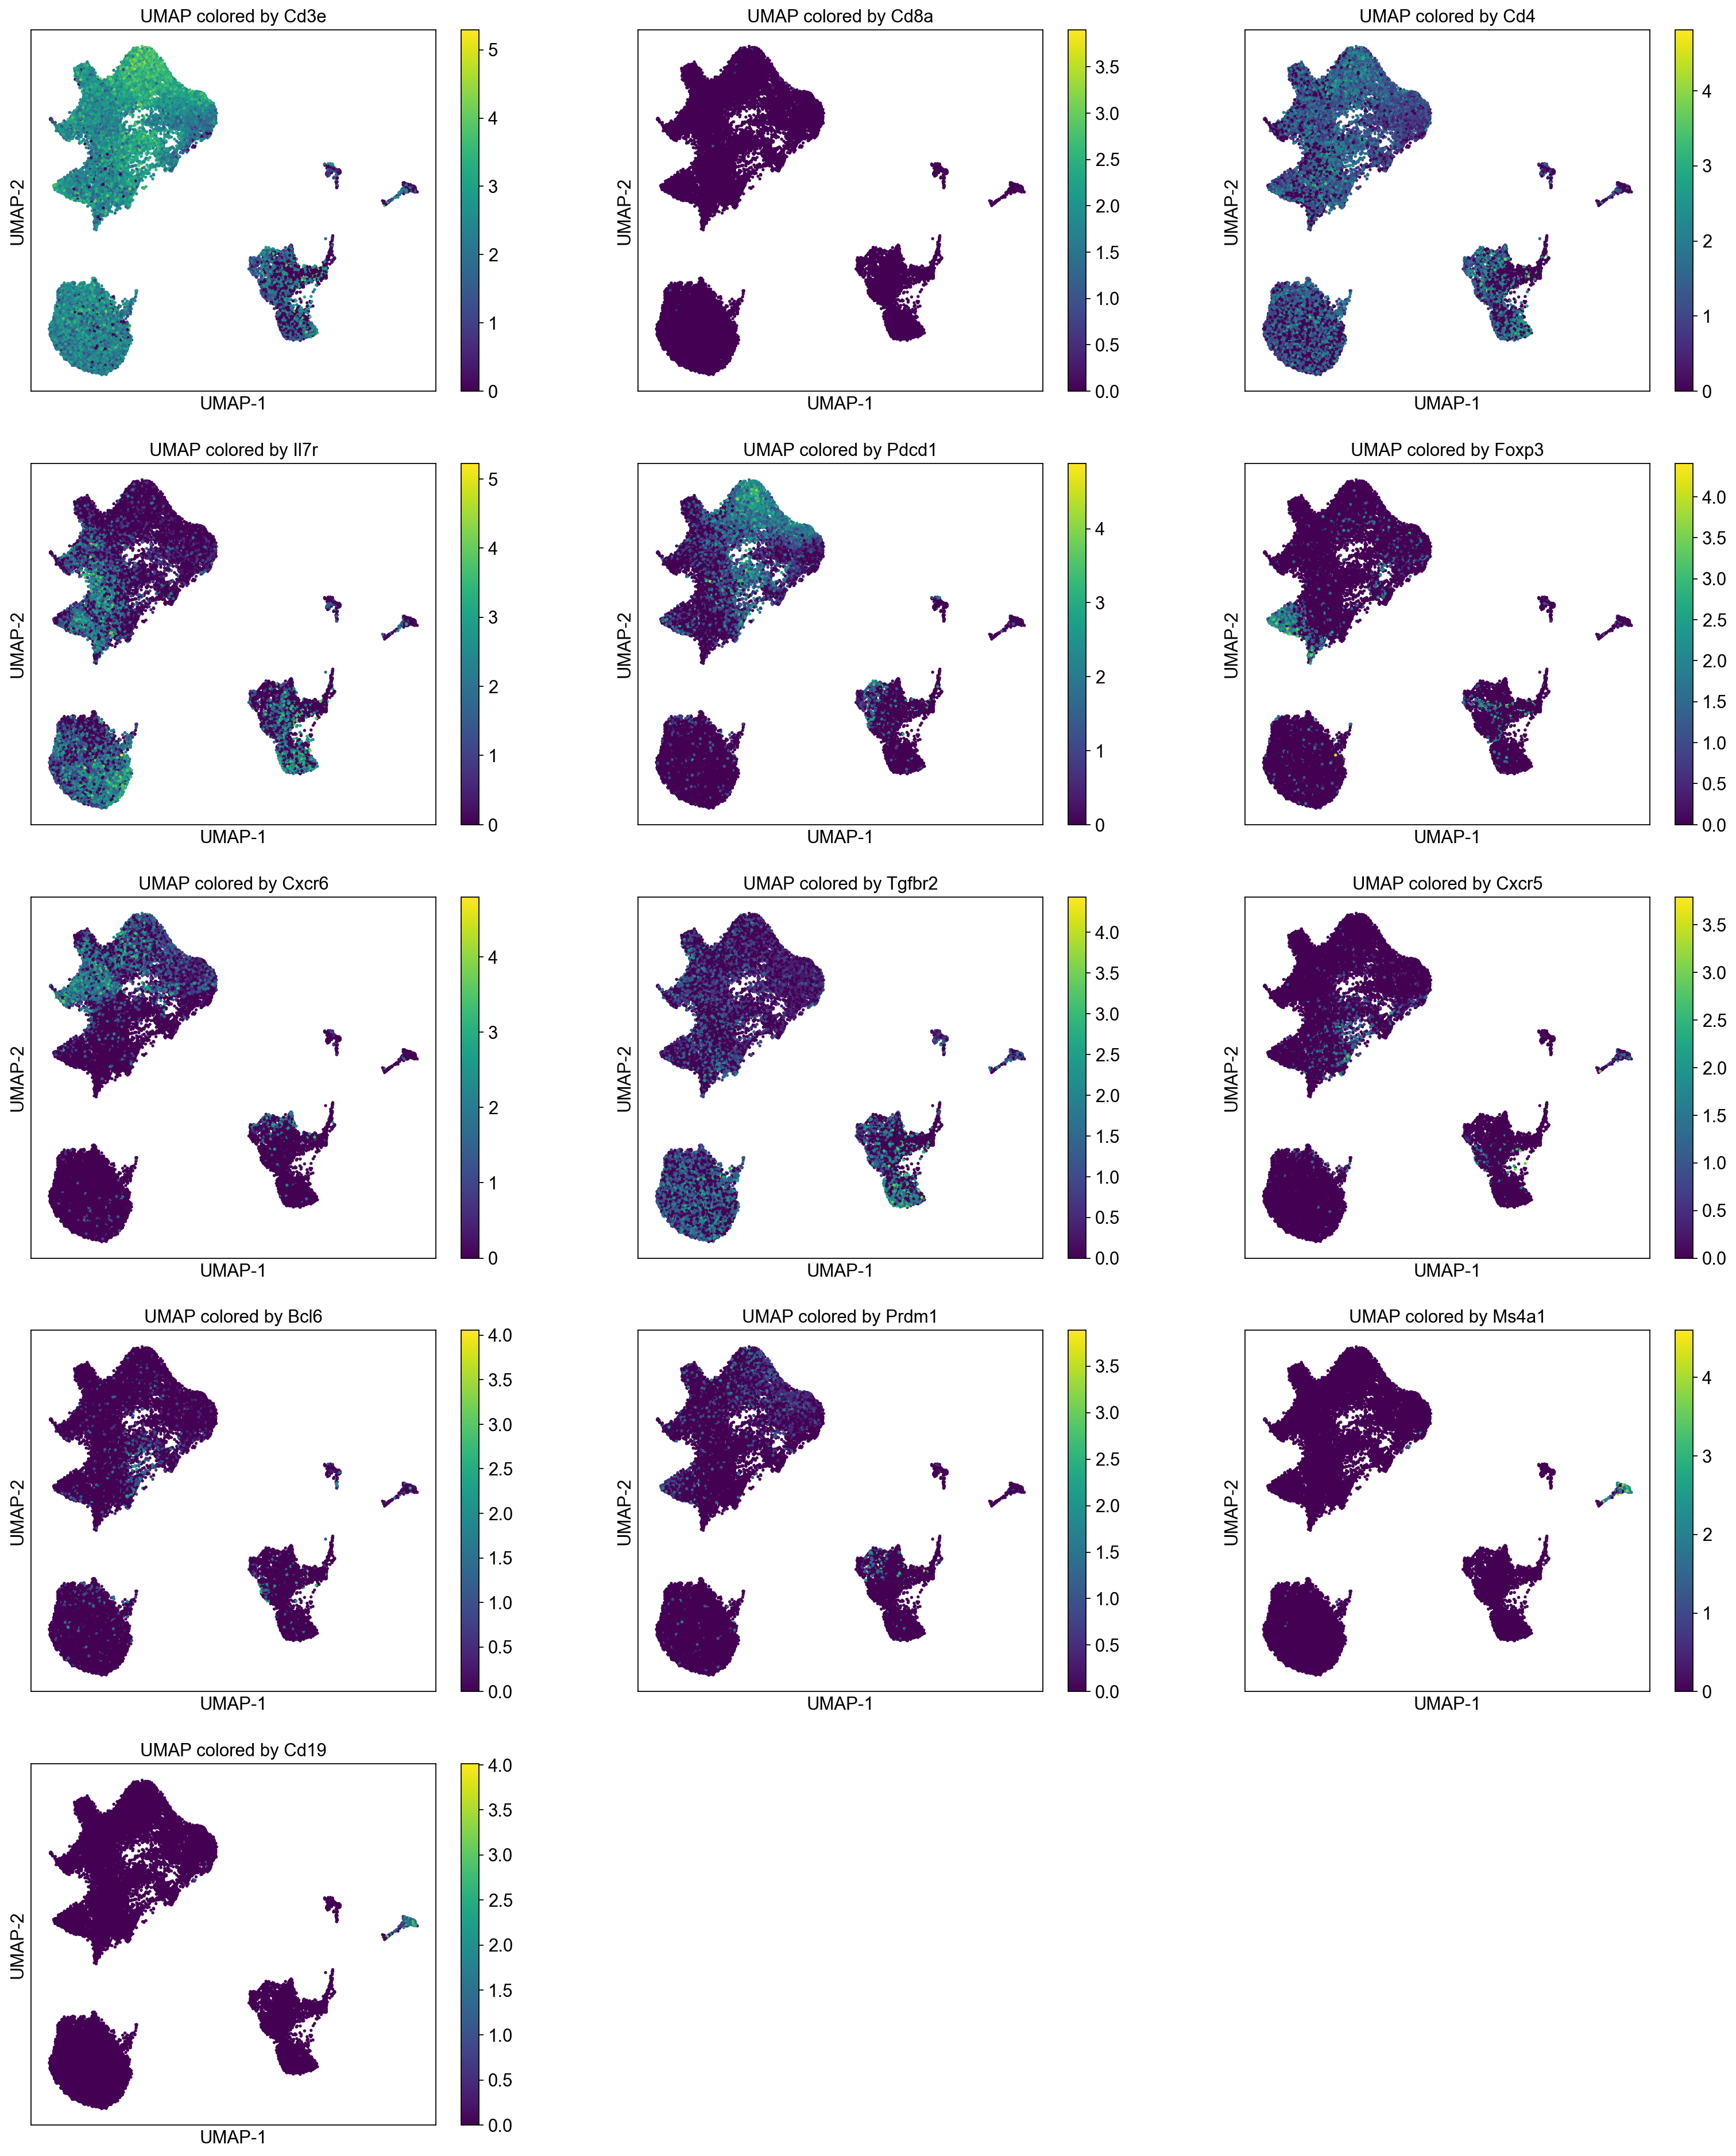

In [ ]:
genes = ['Cd3e', 'Cd8a', 'Cd4', 'Il7r', 'Pdcd1', 'Foxp3', 'Cxcr6', 'Tgfbr2', 'Cxcr5', 'Bcl6', 'Prdm1', 'Ms4a1', 'Cd19']

fig_nrow = 5
fig_ncol = 3

fig = plt.figure(figsize = (8*fig_ncol, 6*fig_nrow))
count = 0
for gene_name in genes:
    ax = fig.add_subplot(fig_nrow, fig_ncol, count + 1)
    col_gene = adata.X[:, adata.var_names.get_loc(gene_name)]
    im1 = ax.scatter(adata.obsm['X_umap'][:, 0], adata.obsm['X_umap'][:, 1], s = 2, c = col_gene, 
                    cmap = 'viridis')
    ax.set_xlabel('UMAP-1', fontsize = 14)
    ax.set_ylabel('UMAP-2', fontsize = 14)
    ax.set_title('UMAP colored by ' + gene_name, fontsize = 14)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.colorbar(im1)
    count = count + 1
    
# To save, please uncomment the following line of code:
# fig.savefig(output_directory, 'UMAP_colored_by_genes.png', dpi = 150, bbox_inches = 'tight')

### Clustering

In [ ]:
sc.external.tl.phenograph(adata, clustering_algo='louvain', k=30, jaccard=True, primary_metric='euclidean', 
                          resolution_parameter=1)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 3.2899160385131836 seconds
Jaccard graph constructed in 7.973415851593018 seconds
Wrote graph to binary file in 1.0821540355682373 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.852949
Louvain completed 21 runs in 48.11524772644043 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 63.023792028427124 seconds


In [ ]:
import scipy
adata.obsp['pheno_jaccard_ig'] = scipy.sparse.csr_matrix(adata.obsp['pheno_jaccard_ig'])

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


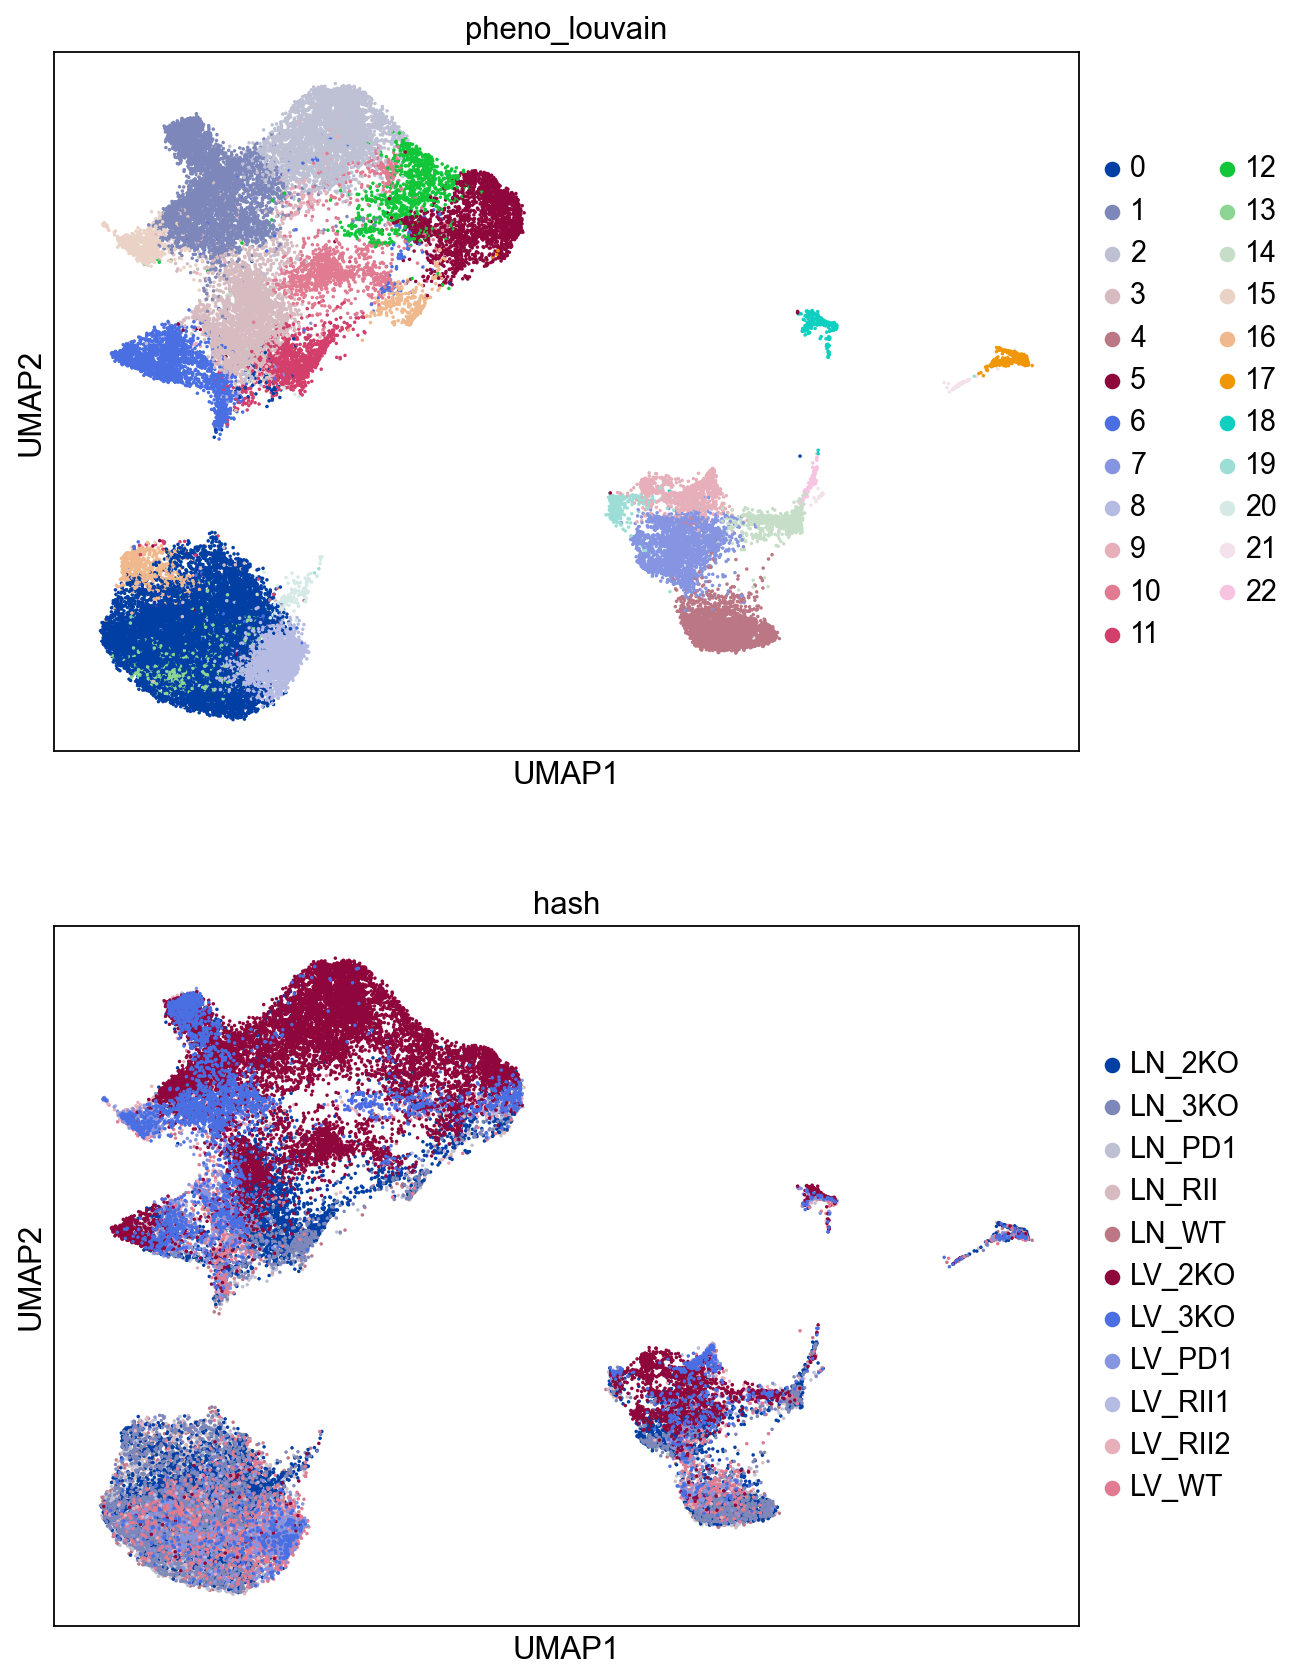

In [ ]:
sc.set_figure_params(scanpy=True, fontsize = 14, figsize = (8, 6))
sc.pl.umap(adata, color = ['pheno_louvain', 'hash'], s = 10, palette = sc.pl.palettes.zeileis_28, ncols = 1)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby = 'pheno_louvain', groups='all', reference='rest', method='wilcoxon')

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarni

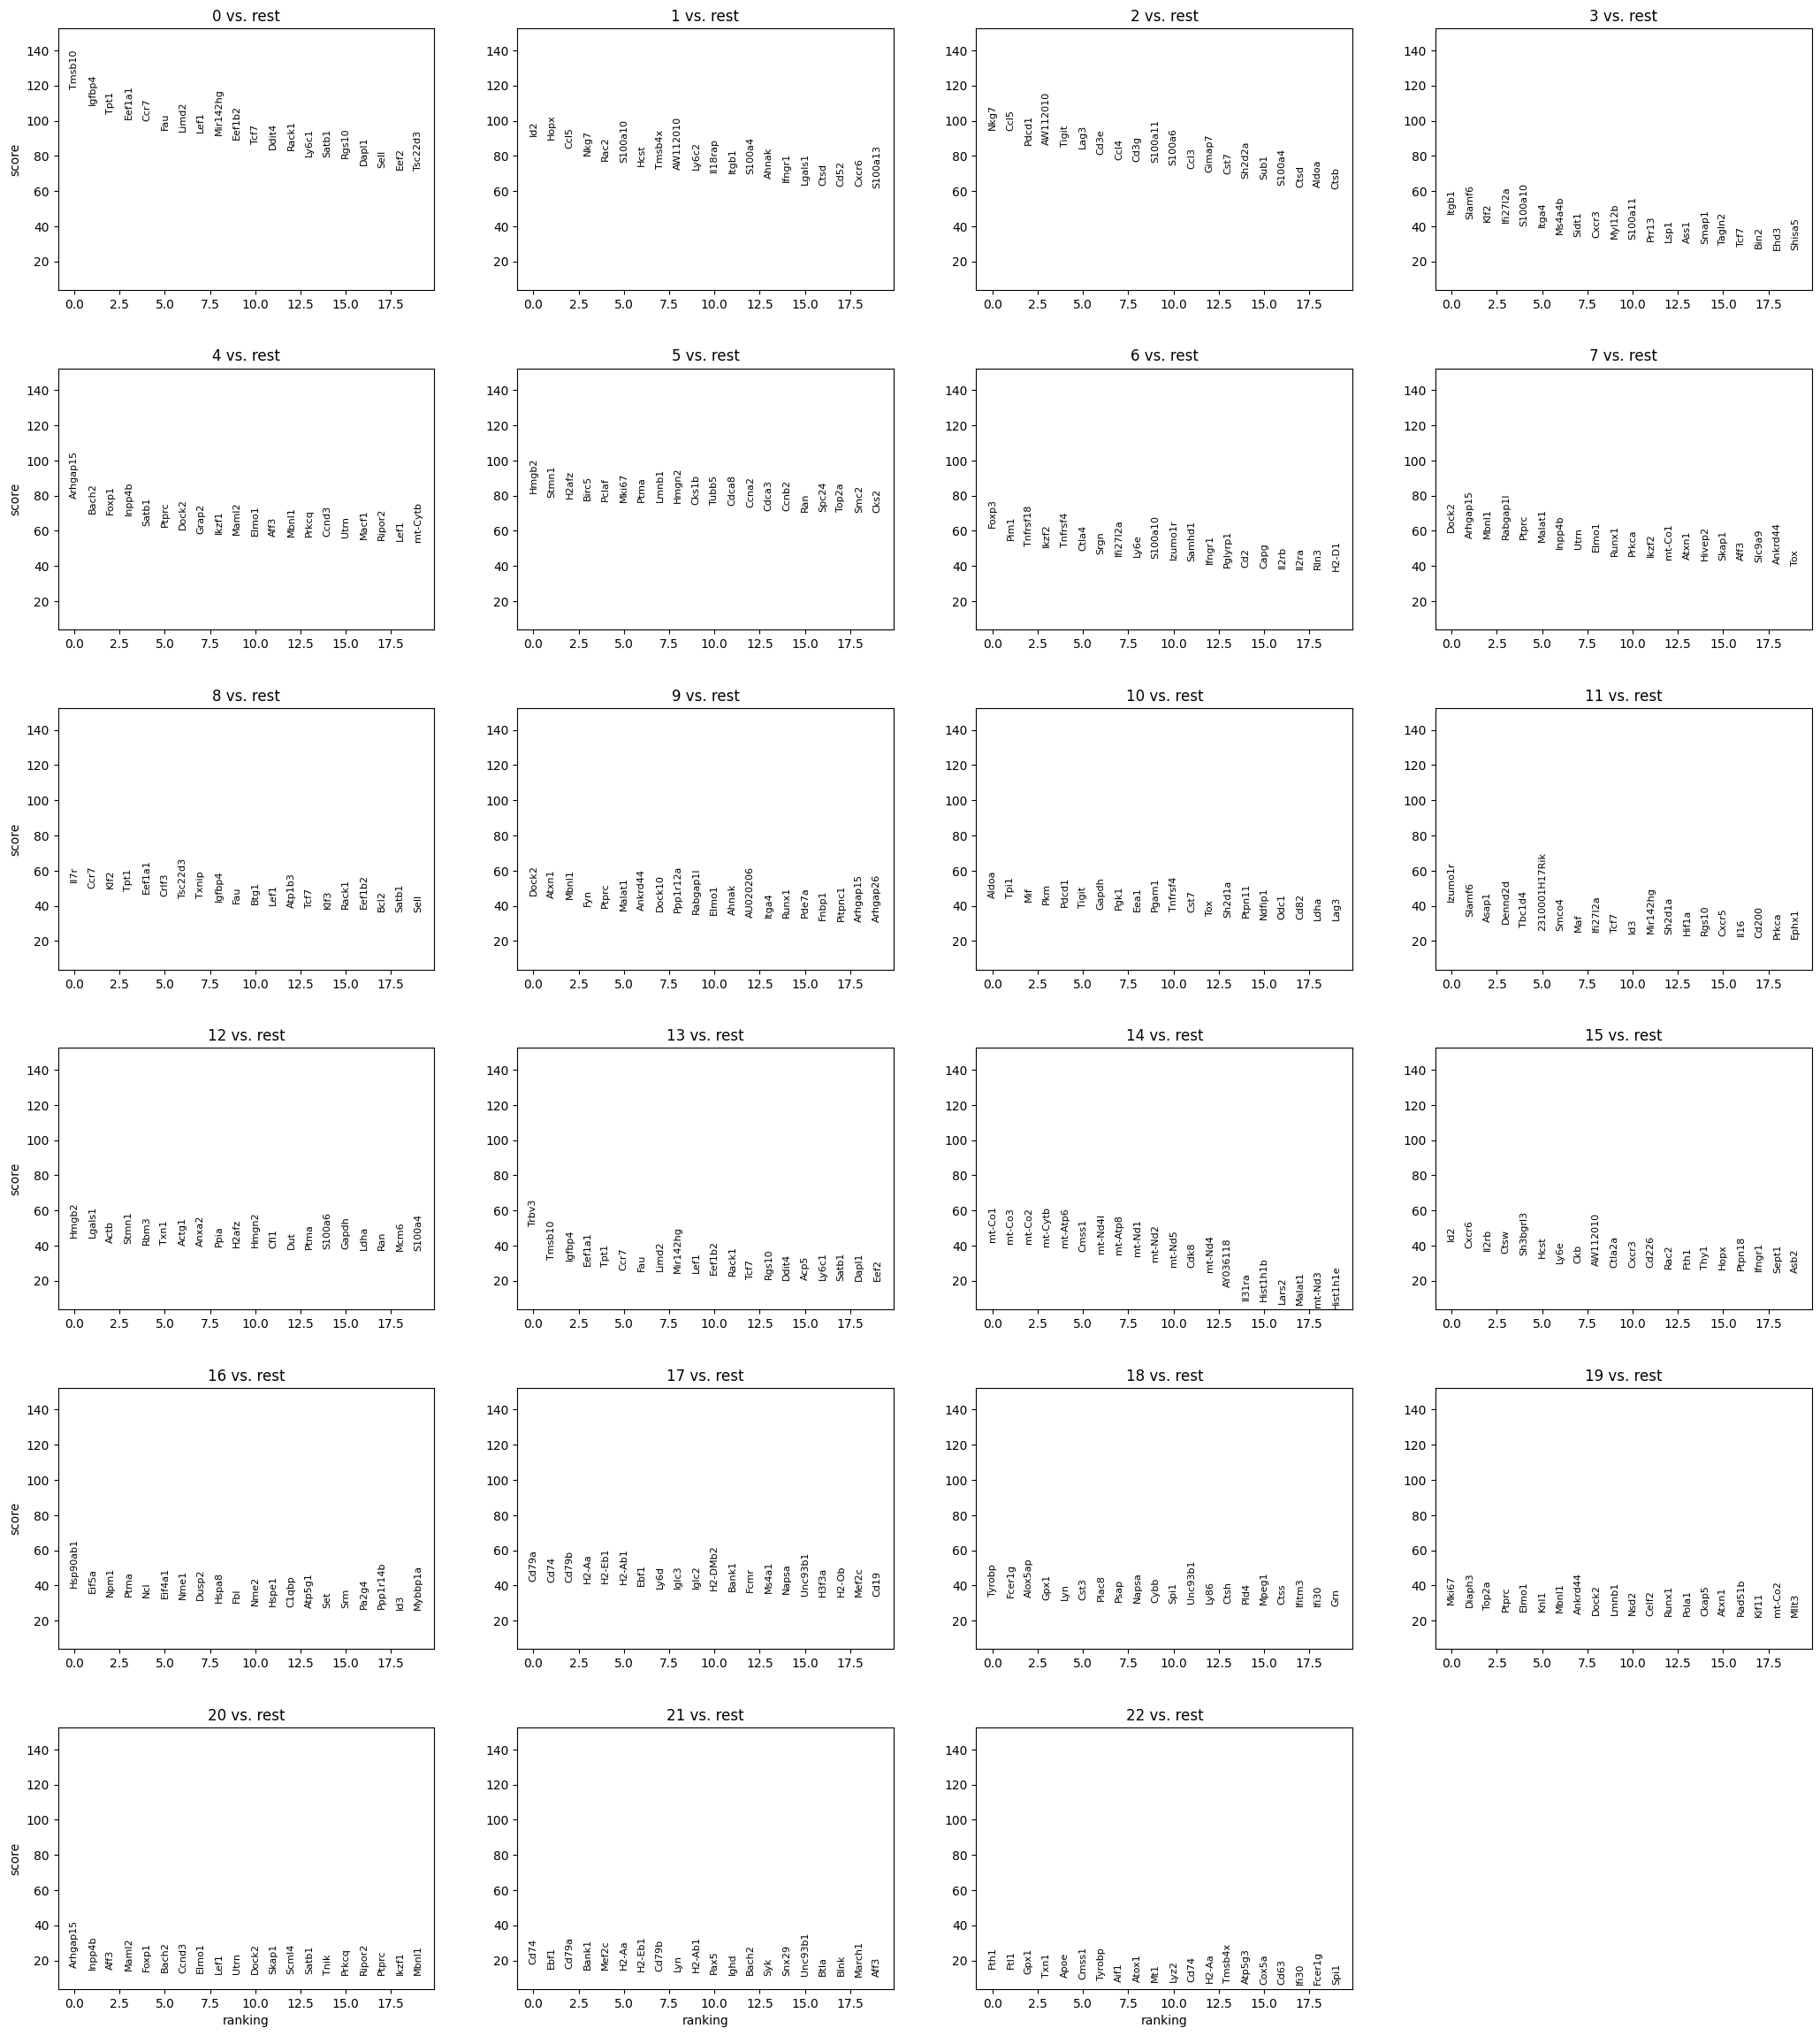

In [ ]:
sc.pl.rank_genes_groups(adata)

#### conclusions

In [ ]:
# 14 is dead cells
# 17 is B cells: CD79, CD20 (MS4a1), CD19
# 18 is suspicious but I'm not so sure what they are

In [ ]:
df_cluster18 = sc.get.rank_genes_groups_df(adata, group = '18')
# To see top 20:
df_cluster18.iloc[0:20, :]

names     scores  logfoldchanges          pvals      pvals_adj
0    Tyrobp  33.738995       10.200400  1.550317e-249  2.495390e-245
1    Fcer1g  33.444839        9.791433  3.059005e-245  2.461887e-241
2   Alox5ap  33.026016       10.883597  3.438141e-239  1.844677e-235
3      Gpx1  31.689287        4.066599  2.182500e-220  8.782379e-217
4       Lyn  31.608154        6.168187  2.852624e-219  9.183169e-216
5      Cst3  31.557529        4.990342  1.413524e-218  3.792014e-215
6     Plac8  31.297232        7.746959  5.089208e-215  1.170227e-211
7      Psap  30.897671        4.408381  1.283725e-209  2.582855e-206
8     Napsa  30.159500        5.926421  8.051661e-200  1.439995e-196
9      Cybb  30.118980        6.535909  2.734363e-199  4.401231e-196
10     Spi1  29.910561        8.152916  1.434411e-196  2.098935e-193
11  Unc93b1  29.817244        5.003909  2.335171e-195  3.132242e-192
12     Ly86  29.519079        6.946994  1.638478e-191  2.028688e-188
13     Ctsh  29.497986        7.132101  3.055447e-191  3.512892e-188
14     Pld4  29.493279        7.715666  3.511035e-191  3.767574e-188
15    Mpeg1  29.397038        8.938971  5.991952e-190  6.027904e-187
16     Ctss  29.108040        3.879383  2.840117e-186  2.689090e-183
17   Ifitm3  28.454691        8.414924  4.263462e-178  3.812483e-175
18    Ifi30  28.389524        4.890240  2.723684e-177  2.307390e-174
19      Grn  28.379902        5.060215  3.580243e-177  2.881380e-174

### scrublet for doublet detection

In [ ]:
adata_scrublet = sc.AnnData(adata.layers['raw_data'], obs = adata.obs, var = adata.var)

sc.external.pp.scrublet(adata_scrublet, sim_doublet_ratio=2.0, expected_doublet_rate=0.06, 
                        knn_dist_metric='euclidean', log_transform=True, n_prin_comps=30, 
                        random_state=0)

adata.obs[['doublet_score', 'predicted_doublet']] = adata_scrublet.obs[['doublet_score', 'predicted_doublet']]
adata.obs['predicted_doublet_as_string'] = adata_scrublet.obs['predicted_doublet'].astype('str')
adata.uns['scrublet'] = adata_scrublet.uns['scrublet']

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 25.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.6%


/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


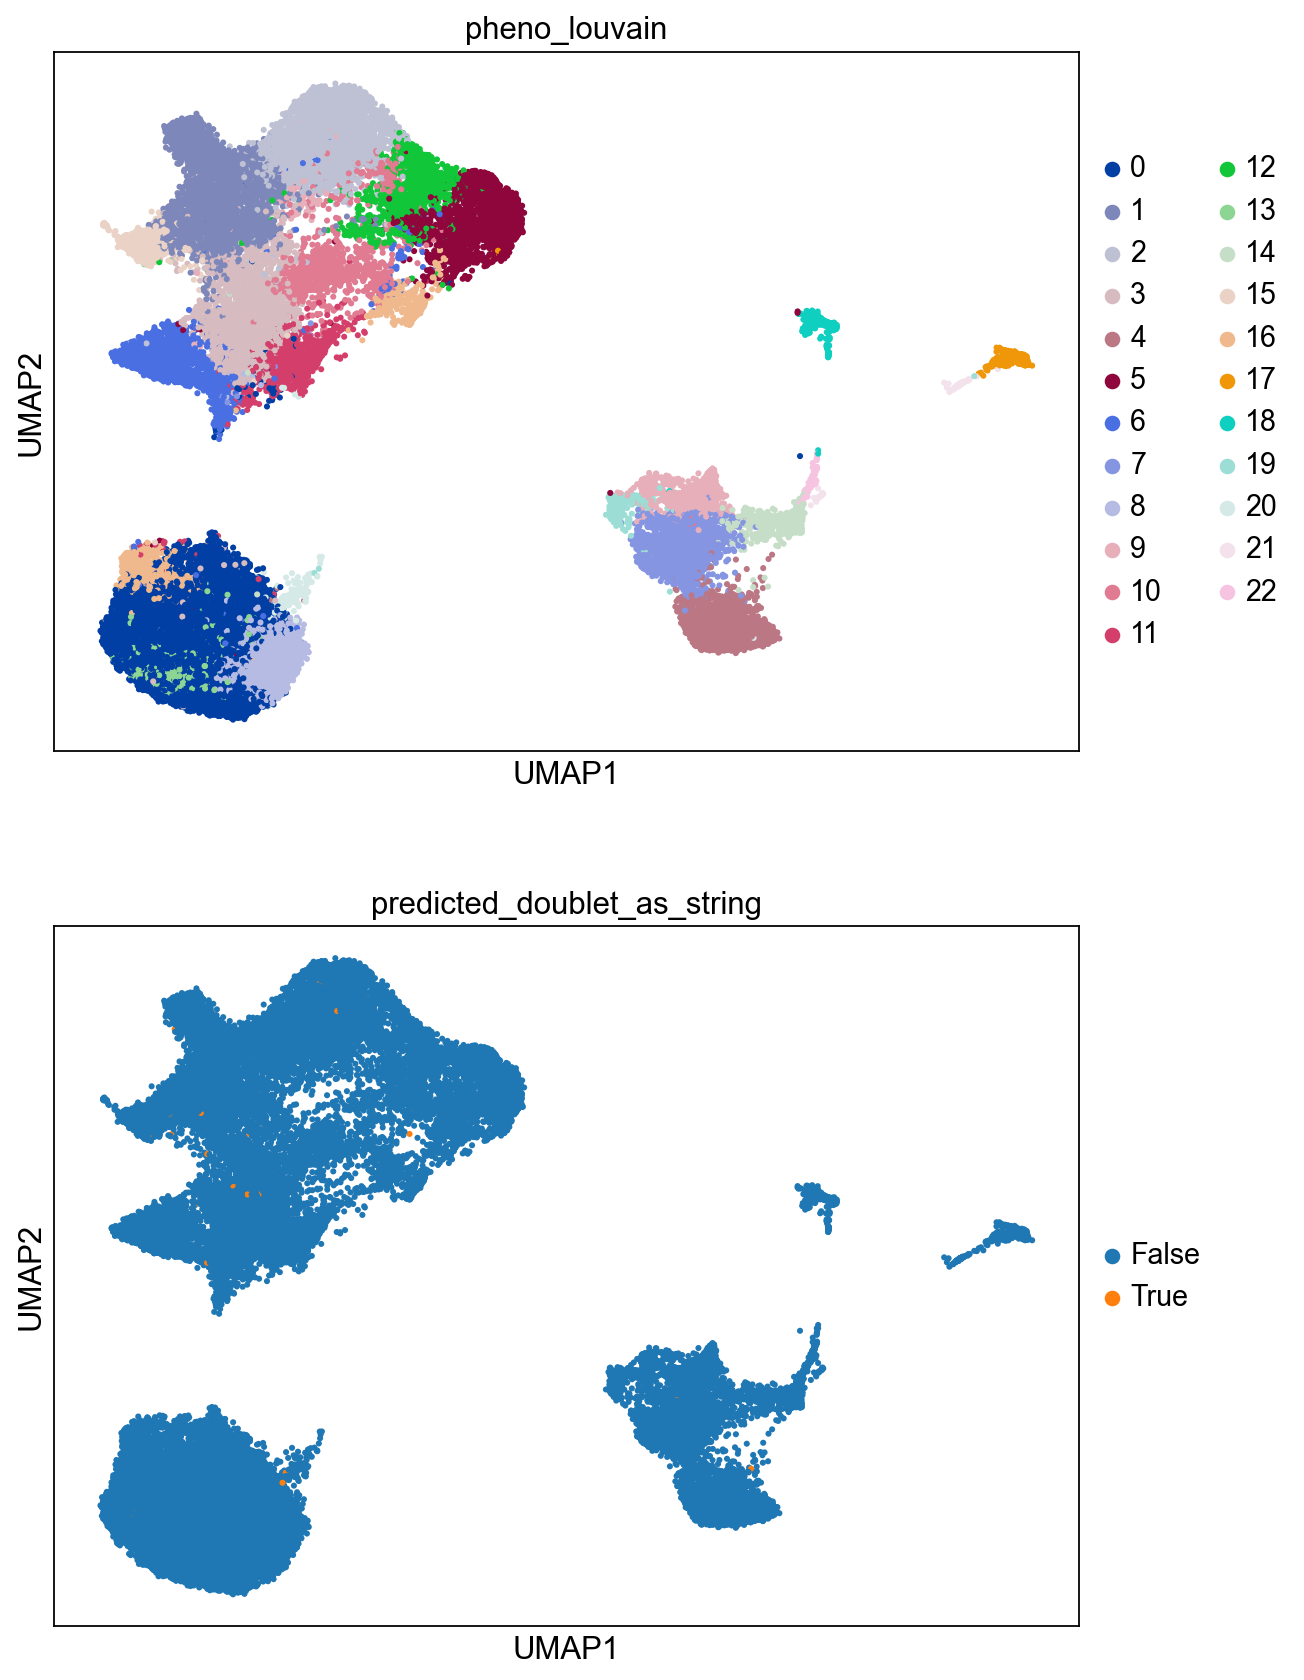

In [ ]:
sc.set_figure_params(scanpy=True, fontsize = 14, figsize = (8, 6))
sc.pl.umap(adata, color = ['pheno_louvain', 'predicted_doublet_as_string'], size = 30, ncols = 1)

#### conclusions

In [ ]:
# very few doublet, nothing to remove

### Conclusions

In [ ]:
# remove 14, 17
cells_remove = np.isin(adata.obs['pheno_louvain'], [14, 17])
adata_clean = sc.AnnData(adata.X[~cells_remove, :], 
                         obs = adata.obs.iloc[~cells_remove, :], 
                         var = adata.var)
adata_clean.layers['norm_counts'] = adata.layers['norm_counts'][~cells_remove, :].copy()
adata_clean.layers['raw_data'] = adata.layers['raw_data'][~cells_remove, :].copy()
adata_clean.layers['zs_norm_log'] = adata.layers['zs_norm_log'][~cells_remove, :].copy()

/Users/gaos1/anaconda3/envs/py38/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


#### Save

In [ ]:
# save adata and adata_clean
adata.write_h5ad('normalized_gex_all_no_ribo_clustering.h5ad')

In [ ]:
adata_clean.write_h5ad('normalized_gex_all_no_ribo_clustering_remove_B_mito.h5ad')

In [ ]:
adata_clean

AnnData object with n_obs × n_vars = 44489 × 16096
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac', 'pheno_louvain', 'doublet_score', 'predicted_doublet', 'predicted_doublet_as_string'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'norm_counts', 'raw_data', 'zs_norm_log'

In [ ]:
adata

AnnData object with n_obs × n_vars = 46095 × 16096
    obs: 'hash', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_frac', 'ribo_frac', 'pheno_louvain', 'doublet_score', 'predicted_doublet', 'predicted_doublet_as_string'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'id_hvg', 'pca', 'loadings', 'neighbors_30', 'umap', 'hash_colors', 'pheno_jaccard_q', 'pheno_louvain_colors', 'rank_genes_groups', 'scrublet', 'predicted_doublet_as_string_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'norm_counts', 'raw_data', 'zs_norm_log'
    obsp: 'neighbors_30_distances', 'neighbors_30_connectivities', 'pheno_jaccard_ig'

## END